# VQE. tight binding + sd-interaction + on-site Coulomb repulsion, generic ansatz


In [24]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
#from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, depolarizing_error

#math modules
import math
import numpy as np

# SciPy minimizer routine
from scipy.optimize import minimize

import time

#My libraries
import vqe_funcs

In [2]:
PI = np.pi

In [3]:
from vqe_funcs import sigma_x, sigma_y, sigma_z, kinetic_energy, full_ham

## Magnetization distirbution

In [4]:
#Uniform magnetization along z axis
#nodes_number = 4
#mag = []

def uniform_z(nodes_number):
    mag = []
    for i in range(nodes_number):
        mag.append([0, 0, 1])
    return mag

## Generic ansatz

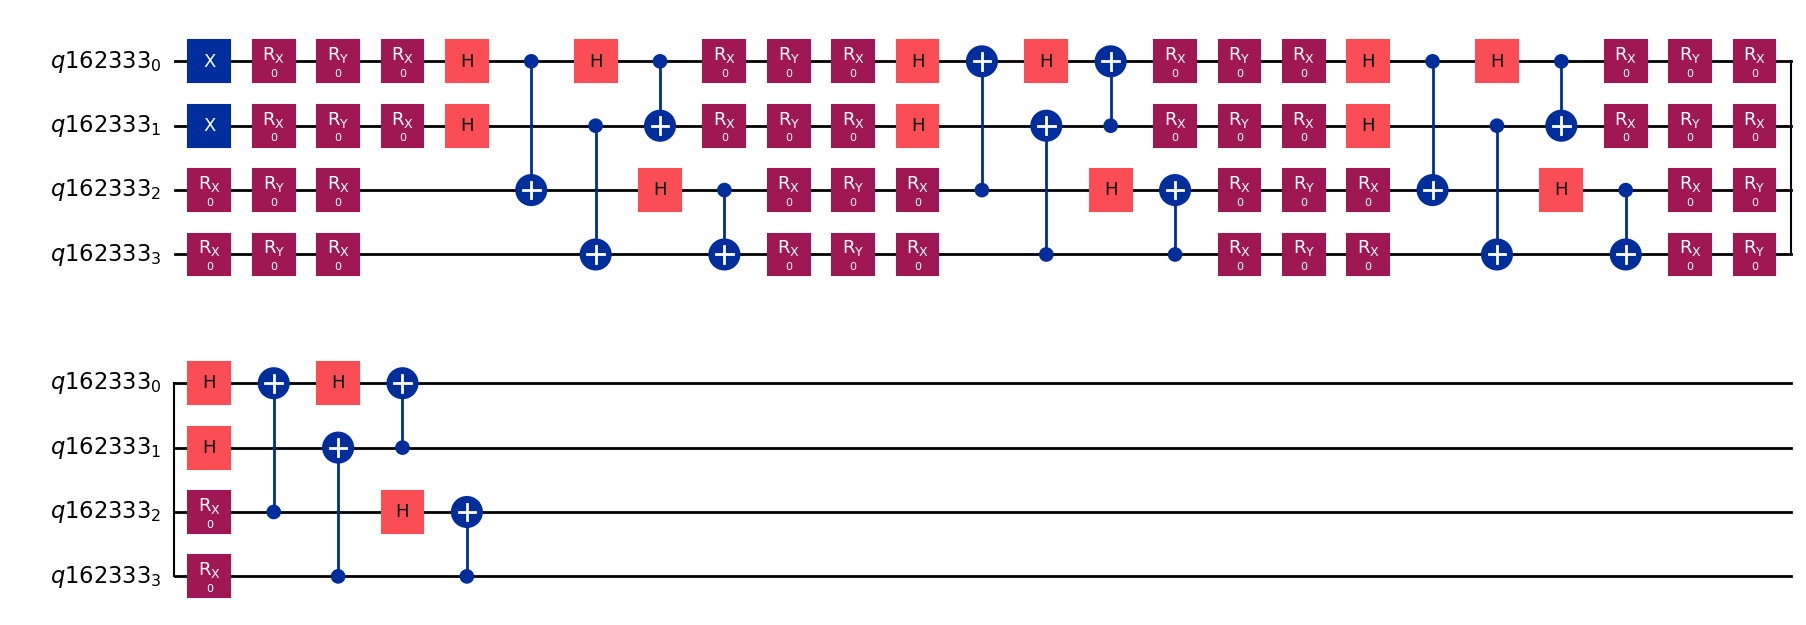

In [127]:
def anzatz_qc(theta, nodes_number, el_num):
    #theta should have 4 * 3 * 2 * nodes_number elements 
    
    #initial guess creatin
    q_r = Q_R(nodes_number * 2)
    v_qc = QuantumCircuit(q_r)
    
    #Initial guess preparation
    #v_qc.h(0)
    #for i in range(2 * nodes_number - 1):
    #    v_qc.cx(i, i + 1)
    #for i in range(nodes_number):
    #    if i % 2 == 0:
    #        v_qc.x(i)
    #for i in range(nodes_number, 2 * nodes_number):
    #    if (i - nodes_number) % 2 != 0:
    #        v_qc.x(i)

    for i in range(el_num):
        v_qc.x(i)
    #variational block        
    i_theta = 0
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1

    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i, i + nodes_number)
    for i in range(0, nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
    for i in range(nodes_number, 2 * nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
        
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i + nodes_number, i)
    for i in range(0, nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
    for i in range(nodes_number, 2 * nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)

    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1

    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i, i + nodes_number)
    for i in range(0, nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
    for i in range(nodes_number, 2 * nodes_number-1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
        
    for i in range(0, nodes_number * 2):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    
    for i in range(0, nodes_number):
        v_qc.h(i)
        v_qc.cx(i + nodes_number, i)
    for i in range(0, nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
    for i in range(nodes_number, 2 * nodes_number - 1):
        v_qc.h(i)
        v_qc.cx(i + 1, i)
        
    return v_qc

n_nodes = 2
n_el = 2
theta = [0*PI/2] * (4 * 3 * 2 * n_nodes)
qc = anzatz_qc(theta, n_nodes, n_el)
pass_manager = generate_preset_pass_manager(3, AerSimulator())
v_qc_isa = pass_manager.run(qc)
v_qc_isa.draw('mpl')
qc.draw('mpl')

In [128]:
(4 * 3 * 2 * n_nodes)

48

In [129]:
qc.decompose().count_ops()

OrderedDict([('r', 48), ('u2', 16), ('cx', 16), ('u3', 2)])

## Cost function

In [7]:
# Cost function. Noiseless simulator is used. No real QC is used.
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, nodes_number, hamiltonian, electrons_number):
    v_qc = anzatz_qc(theta, nodes_number, electrons_number)
    
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [100]:
# Cost function. NOISY simulator is used. No real QC is used.
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim_noise(theta, nodes_number, hamiltonian, electrons_number):
    noise_model = NoiseModel()
    cx_depolarizing_prob = 0.01
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
    )
    
    
    v_qc = anzatz_qc(theta, nodes_number, electrons_number)
    pass_manager = generate_preset_pass_manager(3, AerSimulator())
    v_qc_isa = pass_manager.run(v_qc)
    #v_qc_isa.draw('mpl')
    noisy_estimator = Estimator(
        options = dict(backend_options=dict(noise_model=noise_model))
   )
    
    #Run the estimator 
    pub = (v_qc_isa, hamiltonian)
    job = noisy_estimator.run([pub])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [99]:
#comparing NOISY estimator and IDEAL estimator using the initial guess of the ansatz using classical simulations of QC
nodes_number = 3
electrons_number = 3
J = 0.10 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
electrons_number = 3
n_red = 0
U_c = 10

n_qubits = nodes_number * 2
len_tot = 4 * 3 * 2 * nodes_number

theta = [0]
for i in range(len_tot):
    theta.append(PI/3)


hamiltonian = full_ham(nodes_number, uniform_z(nodes_number), J, t, U_c, periodic = False)
#print(hamiltonian)
print(['noisy estimator: ', str(estim_noise(theta, nodes_number, hamiltonian, electrons_number)),'\n'])
print(['ideal estimator: ', str(estim(theta, nodes_number, hamiltonian, electrons_number)),'\n'])


['noisy estimator: ', '-0.47859389567156674', '\n']
['ideal estimator: ', '-0.47859389567156674', '\n']


## Main optimization codes

## Noiseless optimization

In [130]:
# Hamiltonian parameters
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.20 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 10

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)
n_qubits = nodes_number * 2

mag = []
mag = uniform_z(nodes_number)

#initialize the state

len_tot = 4 * 3 * 2 * nodes_number
x0 = []
for i in range(len_tot):
    x0.append(0)

#define the Hamiltonian
hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)
#print(hamiltonian)
#Optimization
start = time.time()
res = minimize(
        estim,
        x0,
        args=(nodes_number , hamiltonian, electrons_number),
        method="cobyla",
        options={"maxiter":  1000} #, "rhobeg": 1
    )
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
#print(res)
#print(cost_history_dict)

['time elapsed: 48.242706298828125 sec']


## Noisy optimization

In [38]:
# Hamiltonian parameters
nodes_number = 3 #number of nodes
electrons_number = 3
J = 0.10 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)

U_c = 10

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)
n_qubits = nodes_number * 2


mag = []
mag = uniform_z(nodes_number)

#initialize the state

len_tot = 4 * 3 * 2 * nodes_number
x0 = []
for i in range(len_tot):
    x0.append(random.random() * 0.00)

#define the Hamiltonian
hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)
#print(hamiltonian)
#Optimization
start = time.time()
res = minimize(
        estim_noise,
        x0,
        args=(nodes_number , hamiltonian, electrons_number),
        method="cobyla",
        options={"maxiter":  10000} #, "rhobeg": 1
    )
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
#print(res)
#print(cost_history_dict)

['time elapsed: 690.3909990787506 sec']


## Showing the energy convergence

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -8.968082714666956
       x: [-5.807e-02 -1.034e-01 ...  1.432e+00 -6.272e-01]
    nfev: 1000
   maxcv: 0.0


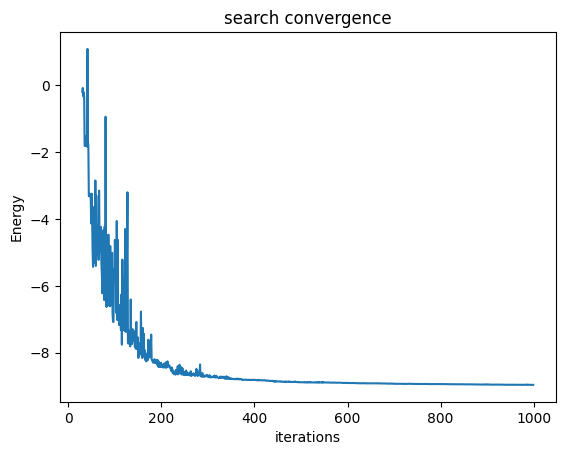

In [131]:
import matplotlib.pyplot as plt
print(res)
en = cost_history_dict["cost_history"]
iterations = range(len(en))
# Create the plot
plt.plot(iterations[30:10000], en[30:10000])

# Add labels and title
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.title('search convergence')

# Display the plot
plt.show()

## Showing the ground state wave function

In [132]:
q_r = Q_R(nodes_number * 2)
cl_r = C_R(nodes_number * 2)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, nodes_number, electrons_number)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

#qc_f.decompose().draw('mpl')

from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ground_state = result.get_statevector(circ)

import sys
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')
import aux_func as af
n_nonzero = 0
n_states = pow(2, 2 * nodes_number)
states = []
prob = []
for i in range(n_states):
    pr = pow(abs(ground_state[i]), 2)
    if pr>0.01: #0/n_states/2:
        n_nonzero = n_nonzero + 1
        states.append(i)
        prob.append(pr)
        print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    
print('Energy: ' + str(res.fun))

state: 0011, prob: 0.01595627588082082, complex amplitude: (-0.12214058247693205-0.03221729338440123j)
state: 0110, prob: 0.21195008608119795, complex amplitude: (0.03699722488673438-0.4588913721480045j)
state: 1001, prob: 0.1001096781027429, complex amplitude: (-0.1954927139943242-0.24878158468398792j)
state: 1100, prob: 0.6678854972591288, complex amplitude: (-0.3023066195568838+0.7592734718342387j)
Energy: -8.968082714666956


# Comparison of the wave functions

In [133]:
#Wave functions obtained using direct diagonalization
'''
n_el = 3
n_nodes = 3
t = 1
U_c = 10
J = 0.1
periodic = False
'''
wf_direct = [0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 2.106603489036304e-17, 0, 9.186806148044368e-19, -1.5890183584342001e-18, 0, 0, 0, 0, -1.0935400105641302e-16, 0, -3.219488866582957e-18, 1.3078453917409573e-20, 0, 0, 0.0059311335996811996, -0.06019226218102869, 0, 0.4052647713949007, 0, 0, 0, 0, 0, 0, -1.4931386473248588e-18, 0, 2.2189988933046027e-19, 1.7769559273632148e-21, 0, 0, -0.06019226218102869, 0.8105295427898014, 0, -0.060192262181028626, 0, 0, 0, 0, 0.4052647713949007, -0.060192262181028744, 0, 0.005931133599681469, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
'''
n_el = 2
n_nodes = 2
t = 0.001
U_c = 10
J = 20
periodic = False
'''
wf_direct = [0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 1.0, 0, 0, 0]

In [134]:
# Product of the precise WF and the VQE optimized WF
abs(np.dot(ground_state, wf_direct))

0.8172426183570757